In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])
import utils
from utils import get_all_bounding_boxes, segment, calculate_initial_theta, stack_alpha_aware, AestheticPredictor
from lion_pytorch import Lion
from datetime import datetime
import random

In [55]:
im = Image.open('combined/5373.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]
even_more_reduced_segments = [reduced_segments[i] for i in [2,4,5,6,7,8,10,11,12]]

In [66]:
class MultiSegmentUIOptimizerWithBackgroundParam(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            # initial_theta = calculate_initial_theta(segment,original_image_size,position)
            initial_theta = get_random_initial_position(segment,original_image_size,position)
            initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        print(self.coordinates)
        self.background_color = torch.nn.Parameter(torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float))
        

    def forward(self):
        segments_on_canvas = []

        # Create background image from parameter
        bg_col = torch.clamp(self.background_color, min=0, max=1)
        #print(f"Clamped bg to {bg_col}")
        red = torch.tile(bg_col[0],self.original_image_size[::-1])
        green = torch.tile(bg_col[1],self.original_image_size[::-1])
        blue = torch.tile(bg_col[2],self.original_image_size[::-1])
        alpha = torch.tile(torch.tensor(0.0),self.original_image_size[::-1])
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        #print(background.detach().sum())
        #background = torch.tile(self.background_color,self.original_image_size)
        
        
        for n in range(len(self.segments_and_positions)):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            
            # Affine matrix
            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]

            theta_tensor[0][0][2]+=self.coordinates[n][0]
            theta_tensor[0][1][2]+=self.coordinates[n][1]
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)

        segments_on_canvas.append(background)

        return segments_on_canvas

In [67]:
msUIo_wbg = MultiSegmentUIOptimizerWithBackgroundParam(even_more_reduced_segments, im.size)

Canvas size is (1, 3, 2560, 1440)
Original would have been: [[ 8.57142857  0.         -5.8047619 ]
 [ 0.         15.23809524 13.30372024]]
Now is [[ 8.57142857  0.          7.31684258]
 [ 0.         15.23809524  2.65351766]]
Original would have been: [[ 2.93279022  0.          1.63213397]
 [ 0.         27.52688172 21.30440188]]
Now is [[  2.93279022   0.          -0.41129897]
 [  0.          27.52688172 -17.48921573]]
Original would have been: [[ 1.69811321  0.          0.58951782]
 [ 0.         18.02816901 12.06605414]]
Now is [[1.69811321e+00 0.00000000e+00 3.12553442e-03]
 [0.00000000e+00 1.80281690e+01 1.64177649e+01]]
Original would have been: [[ 1.62162162  0.          0.52492492]
 [ 0.         10.5785124   5.30559788]]
Now is [[ 1.62162162  0.          0.33632607]
 [ 0.         10.5785124   0.75895244]]
Original would have been: [[ 2.67657993  0.          1.4157786 ]
 [ 0.         33.68421053 11.20966283]]
Now is [[  2.67657993   0.           1.20810922]
 [  0.          33.68421

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


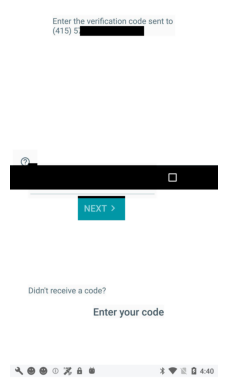

In [68]:
canvasses = msUIo_wbg()


generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))
plt.axis('off')
plt.show()

In [69]:
appsthetics_predictor = torch.load("./resnet_50_20_epochs_2024-05-13T14:03")

In [70]:
appsthetics_predictor.eval()
1

1

In [71]:
# optimizer = Lion(msUIo_wbg.parameters(), lr=0.005)
optimizer = torch.optim.AdamW(msUIo_wbg.parameters(), lr=0.1)

In [72]:
scores = []
images_for_gif = []

for x in tqdm.tqdm(range(50)):
    optimizer.zero_grad()
    canvasses = msUIo_wbg()
    
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]

    score = appsthetics_predictor(generated_image.unsqueeze(0))
    print(score)

    loss = -score
    loss.backward()
    optimizer.step()

    scores.append(score.item())

    # Save image as png to create gif
    pil_image = transform_t_to_pil(generated_image.detach())
    pil_image = pil_image.resize((int(pil_image.size[0]/4),int(pil_image.size[1]/4)), Image.Resampling.LANCZOS)
    pil_image.save(f"{x}.png")
    images_for_gif.append(f"{x}.png")
    #pbar.set_description(f"Score: {score}")
    #pbar.refresh()

print(f"Final Score: {score[-1]}")

  0%|                                                                                                                                                                                                                | 0/50 [00:00<?, ?it/s]

tensor([[0.2966]], grad_fn=<AddmmBackward0>)


  2%|████                                                                                                                                                                                                    | 1/50 [00:09<07:52,  9.64s/it]

tensor([[0.3135]], grad_fn=<AddmmBackward0>)


  4%|████████                                                                                                                                                                                                | 2/50 [00:18<07:09,  8.94s/it]

tensor([[0.3163]], grad_fn=<AddmmBackward0>)


  6%|████████████                                                                                                                                                                                            | 3/50 [00:26<06:54,  8.81s/it]

tensor([[0.2507]], grad_fn=<AddmmBackward0>)


  8%|████████████████                                                                                                                                                                                        | 4/50 [00:35<06:46,  8.84s/it]

tensor([[0.2706]], grad_fn=<AddmmBackward0>)


 10%|████████████████████                                                                                                                                                                                    | 5/50 [00:44<06:36,  8.81s/it]

tensor([[0.2792]], grad_fn=<AddmmBackward0>)


 12%|████████████████████████                                                                                                                                                                                | 6/50 [00:53<06:31,  8.90s/it]

tensor([[0.2947]], grad_fn=<AddmmBackward0>)


 14%|████████████████████████████                                                                                                                                                                            | 7/50 [01:02<06:27,  9.01s/it]

tensor([[0.2969]], grad_fn=<AddmmBackward0>)


 16%|████████████████████████████████                                                                                                                                                                        | 8/50 [01:15<07:07, 10.17s/it]

tensor([[0.3029]], grad_fn=<AddmmBackward0>)


 18%|████████████████████████████████████                                                                                                                                                                    | 9/50 [01:28<07:37, 11.16s/it]

tensor([[0.3012]], grad_fn=<AddmmBackward0>)


 20%|███████████████████████████████████████▊                                                                                                                                                               | 10/50 [01:38<07:14, 10.86s/it]

tensor([[0.3098]], grad_fn=<AddmmBackward0>)


 22%|███████████████████████████████████████████▊                                                                                                                                                           | 11/50 [01:48<06:49, 10.49s/it]

tensor([[0.3300]], grad_fn=<AddmmBackward0>)


 24%|███████████████████████████████████████████████▊                                                                                                                                                       | 12/50 [01:58<06:37, 10.45s/it]

tensor([[0.3358]], grad_fn=<AddmmBackward0>)


 26%|███████████████████████████████████████████████████▋                                                                                                                                                   | 13/50 [02:09<06:26, 10.45s/it]

tensor([[0.3276]], grad_fn=<AddmmBackward0>)


 28%|███████████████████████████████████████████████████████▋                                                                                                                                               | 14/50 [02:20<06:23, 10.64s/it]

tensor([[0.3011]], grad_fn=<AddmmBackward0>)


 30%|███████████████████████████████████████████████████████████▋                                                                                                                                           | 15/50 [02:31<06:17, 10.80s/it]

tensor([[0.3144]], grad_fn=<AddmmBackward0>)


 32%|███████████████████████████████████████████████████████████████▋                                                                                                                                       | 16/50 [02:45<06:36, 11.65s/it]

tensor([[0.3021]], grad_fn=<AddmmBackward0>)


 34%|███████████████████████████████████████████████████████████████████▋                                                                                                                                   | 17/50 [02:59<06:47, 12.36s/it]

tensor([[0.2982]], grad_fn=<AddmmBackward0>)


 36%|███████████████████████████████████████████████████████████████████████▋                                                                                                                               | 18/50 [03:12<06:44, 12.63s/it]

tensor([[0.2990]], grad_fn=<AddmmBackward0>)


 38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 19/50 [03:25<06:39, 12.89s/it]

tensor([[0.2966]], grad_fn=<AddmmBackward0>)


 40%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 20/50 [03:38<06:23, 12.79s/it]

tensor([[0.2942]], grad_fn=<AddmmBackward0>)


 42%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 21/50 [03:50<06:01, 12.48s/it]

tensor([[0.2961]], grad_fn=<AddmmBackward0>)


 44%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 22/50 [04:01<05:40, 12.15s/it]

tensor([[0.2859]], grad_fn=<AddmmBackward0>)


 46%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 23/50 [04:13<05:22, 11.93s/it]

tensor([[0.2936]], grad_fn=<AddmmBackward0>)


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 24/50 [04:23<05:01, 11.60s/it]

tensor([[0.2881]], grad_fn=<AddmmBackward0>)


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 25/50 [04:34<04:45, 11.41s/it]

tensor([[0.2974]], grad_fn=<AddmmBackward0>)


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 26/50 [04:46<04:31, 11.33s/it]

tensor([[0.3018]], grad_fn=<AddmmBackward0>)


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 27/50 [04:58<04:30, 11.78s/it]

tensor([[0.2908]], grad_fn=<AddmmBackward0>)


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 28/50 [05:10<04:17, 11.69s/it]

tensor([[0.3184]], grad_fn=<AddmmBackward0>)


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 29/50 [05:21<03:59, 11.42s/it]

tensor([[0.3246]], grad_fn=<AddmmBackward0>)


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 30/50 [05:31<03:44, 11.22s/it]

tensor([[0.3135]], grad_fn=<AddmmBackward0>)


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 31/50 [05:42<03:30, 11.08s/it]

tensor([[0.3098]], grad_fn=<AddmmBackward0>)


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 32/50 [05:53<03:16, 10.94s/it]

tensor([[0.3022]], grad_fn=<AddmmBackward0>)


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 33/50 [06:04<03:07, 11.01s/it]

tensor([[0.3124]], grad_fn=<AddmmBackward0>)


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 34/50 [06:18<03:10, 11.93s/it]

tensor([[0.3301]], grad_fn=<AddmmBackward0>)


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 35/50 [06:28<02:51, 11.45s/it]

tensor([[0.3358]], grad_fn=<AddmmBackward0>)


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 36/50 [06:39<02:38, 11.34s/it]

tensor([[0.3451]], grad_fn=<AddmmBackward0>)


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 37/50 [06:50<02:26, 11.25s/it]

tensor([[0.3440]], grad_fn=<AddmmBackward0>)


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 38/50 [07:01<02:12, 11.05s/it]

tensor([[0.3294]], grad_fn=<AddmmBackward0>)


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 39/50 [07:12<02:00, 10.95s/it]

tensor([[0.3417]], grad_fn=<AddmmBackward0>)


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 40/50 [07:23<01:49, 10.93s/it]

tensor([[0.3402]], grad_fn=<AddmmBackward0>)


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 41/50 [07:33<01:38, 10.89s/it]

tensor([[0.3298]], grad_fn=<AddmmBackward0>)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 42/50 [07:45<01:27, 10.97s/it]

tensor([[0.3288]], grad_fn=<AddmmBackward0>)


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 43/50 [07:55<01:14, 10.68s/it]

tensor([[0.3348]], grad_fn=<AddmmBackward0>)


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 44/50 [08:05<01:03, 10.63s/it]

tensor([[0.3290]], grad_fn=<AddmmBackward0>)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 45/50 [08:16<00:53, 10.62s/it]

tensor([[0.3467]], grad_fn=<AddmmBackward0>)


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 46/50 [08:26<00:41, 10.48s/it]

tensor([[0.3444]], grad_fn=<AddmmBackward0>)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 47/50 [08:36<00:31, 10.38s/it]

tensor([[0.3523]], grad_fn=<AddmmBackward0>)


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 48/50 [08:46<00:20, 10.28s/it]

tensor([[0.3393]], grad_fn=<AddmmBackward0>)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 49/50 [08:59<00:10, 10.97s/it]

tensor([[0.3353]], grad_fn=<AddmmBackward0>)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [09:10<00:00, 11.02s/it]

Final Score: tensor([0.3353], grad_fn=<SelectBackward0>)


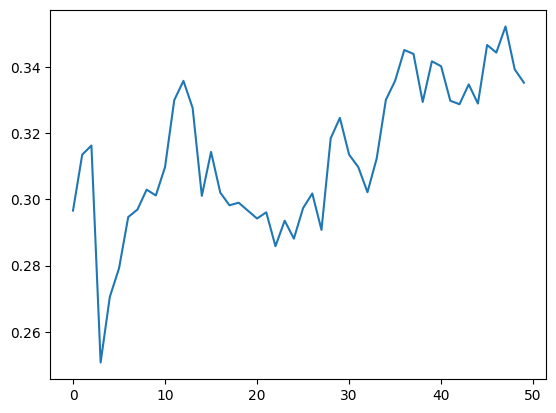

In [75]:
plt.plot(scores)
plt.show()

/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_99213/979258874.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_99213/979258874.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



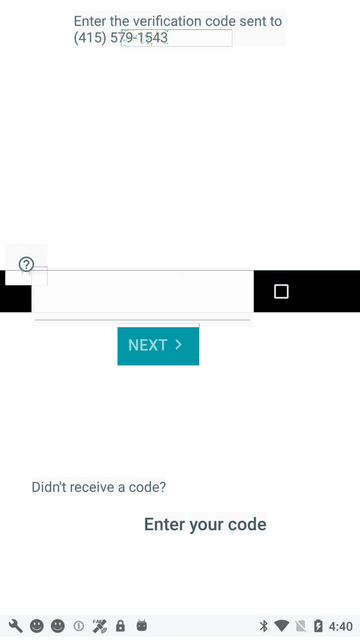

In [74]:
# Create gif from steps
import imageio

images = []
for filename in images_for_gif:
    images.append(imageio.imread(filename))

gif_filename = f"./progress_{datetime.now().isoformat(timespec='minutes')}.gif"
imageio.mimsave(gif_filename, images, loop=65535)

import base64
from IPython.core.display import display, HTML

b64 = base64.b64encode(open(gif_filename,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [65]:
def get_random_initial_position(segment, canvas_size, original_position, seed=1):
    # random.seed(seed)

    
    # Theta consists of 6 values, 4 of which we have to calculate.
    x_ratio = canvas_size[0] / segment.size[0]
    y_ratio = canvas_size[1] / segment.size[1]
    
    mapped_x_position = random.uniform(-(x_ratio-1), (x_ratio-1))
    mapped_y_position = random.uniform(-(y_ratio-1), (y_ratio-1))

    print(f"Original would have been: {calculate_initial_theta(segment,canvas_size,original_position)}")
    print(f"""Now is {np.array([ 
        [x_ratio, 0.0    , mapped_x_position],
        [0.0    , y_ratio, mapped_y_position]
    ])}""")

    
    return np.array([
        [x_ratio, 0.0    , mapped_x_position],
        [0.0    , y_ratio, mapped_y_position]
    ])